<a href="https://colab.research.google.com/github/2403a52030-sketch/NLP-LAB/blob/main/NLP_LAB_13_2030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Core deep learning library
import torch

# Numerical operations
import numpy as np

# Data handling
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face dataset loader
from datasets import load_dataset

# Transformer utilities: tokenizer, model, training
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [13]:
# Load SMS Spam Collection dataset from Hugging Face
dataset = load_dataset("sms_spam")

# Print dataset structure
print(dataset)

# Convert training split to DataFrame for exploration
df = pd.DataFrame(dataset["train"])

# Display first few samples
df.head()

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})


,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


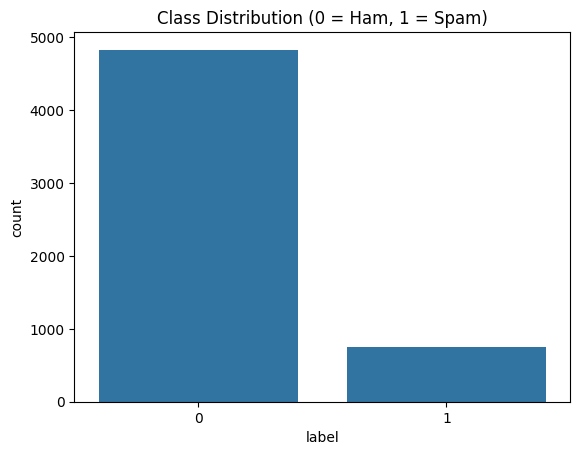

label
0    4827
1     747
Name: count, dtype: int64


In [14]:
# Plot class distribution to check balance
sns.countplot(x="label", data=df)

# Add plot title
plt.title("Class Distribution (0 = Ham, 1 = Spam)")

# Display plot
plt.show()

# Print class counts
print(df["label"].value_counts())

In [15]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Function to tokenize text data
def tokenize_data(batch):
    return tokenizer(
        batch["sms"],            # Input text column
        padding="max_length",    # Pad all sequences to same length
        truncation=True,         # Truncate long sequences
        max_length=128           # Maximum sequence length
    )

# Apply tokenizer to entire dataset
tokenized_dataset = dataset.map(tokenize_data, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [16]:
# Rename label column to 'labels' (required by Hugging Face Trainer)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Convert dataset to PyTorch tensors
tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

In [17]:
# Split dataset into training and testing sets (80:20)
split_data = tokenized_dataset["train"].train_test_split(
    test_size=0.2,
    seed=42
)

# Assign train and test datasets
train_data = split_data["train"]
test_data = split_data["test"]

# Print dataset sizes
print("Training samples:", len(train_data))
print("Testing samples:", len(test_data))

Training samples: 4459
Testing samples: 1115


In [18]:
# Load BERT model for sequence classification
# num_labels = 2 for binary classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [30]:
# Function to compute evaluation metrics
def compute_metrics(pred):
    # True labels
    labels = pred.label_ids

    # Predicted class labels
    preds = np.argmax(pred.predictions, axis=1)

    # Calculate precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    # Return all metrics
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [25]:
# Define training parameters
training_args = TrainingArguments(
    output_dir="./results",                # Output directory
    eval_strategy="epoch",           # Evaluate after each epoch
    learning_rate=2e-5,                    # Learning rate
    per_device_train_batch_size=16,        # Training batch size
    per_device_eval_batch_size=16,         # Evaluation batch size
    num_train_epochs=3,                    # Number of epochs
    weight_decay=0.01,                     # Regularization
    logging_dir="./logs",                  # Logging directory (reverted from TENSORBOARD_LOGGING_DIR)
    logging_steps=100,                     # Log every 100 steps
    save_strategy="no",                    # Do not save checkpoints
    report_to="none"                       # Disable external logging
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [28]:
# Initialize Trainer object
trainer = Trainer(
    model=model,                 # BERT model
    args=training_args,          # Training arguments
    train_dataset=train_data,    # Training dataset
    eval_dataset=test_data,      # Testing dataset
    compute_metrics=compute_metrics  # Metrics function
)

In [ ]:
# Start training the model
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


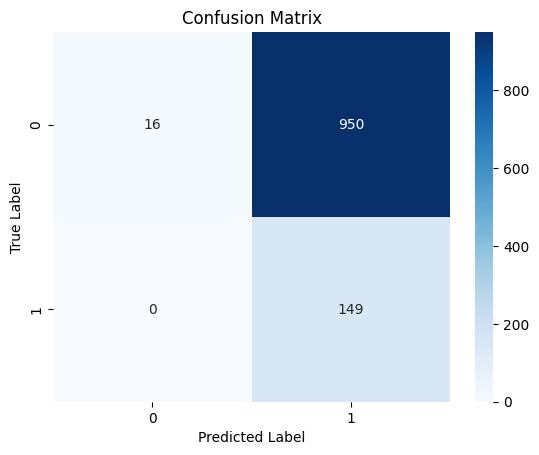

In [29]:
# Get predictions on test dataset
predictions = trainer.predict(test_data)

# Convert logits to predicted labels
y_pred = np.argmax(predictions.predictions, axis=1)

# True labels
y_true = predictions.label_ids

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Label axes
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Display plot
plt.show()